In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
from scipy.optimize import differential_evolution
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
import seaborn as sns

In [3]:
# read tsv file
protein = pd.read_csv('~/CellCyclePlottingDataframes/ProteinPseudotimePlotting.csv', sep='\t')
protein.sort_values('percent_variance', ascending=False, inplace=True)
protein.head()

,ENSG,Antibody,Compartment,CCD,cell_pseudotime,cell_intensity,cell_fred,cell_fgreen,mvavg_x,mvavg_y,mvavgs_10p,mvavgs_90p,mvavgs_25p,mvavgs_75p,phase,gini,percent_variance,WellPlate
18,ENSG00000167065,HPA051349,Nuc,Pseudotime,"0.988,0.972,0.967,0.967,0.953,0.941,0.923,0.91...","0.4134538534404906,0.45366697029678893,0.43499...","-0.5208085575661376,-0.3696105952531643,-0.338...","0.22678169629288636,0.2645050769582622,0.26161...","0.9421,0.9316000000000001,0.9226000000000001,0...","0.5922156625516153,0.6318749547579287,0.676801...","0.4133908942245627,0.4327783409588664,0.432778...","0.8328091747491958,0.8328091747491958,0.876510...","0.43966333826648496,0.4774299687287197,0.55908...","0.7267125708578163,0.8000835463301226,0.823721...","G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G...",0.482745,0.939377,A02_55355986
860,ENSG00000141448,HPA066629,Nuc,Pseudotime,"0.989,0.977,0.972,0.963,0.958,0.956,0.952,0.93...","0.7241060643461584,0.6041150588947811,0.867298...","-0.47719507229814795,-0.4614129334748629,-0.44...","0.19836377479968137,0.3010318949289812,0.31949...","0.9527,0.9441,0.9365000000000001,0.92910000000...","0.8332025304785078,0.8553212281403616,0.865108...","0.6390608845332211,0.6390608845332211,0.696081...","0.9436392210466069,0.9469936135286314,0.946993...","0.7599041751647144,0.8729275352601987,0.872927...","0.9032342062655768,0.9323214019993045,0.932321...","G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G...",0.338809,0.884102,F10_55385989
1090,ENSG00000112312,HPA054597,Nuc,Pseudotime,"0.998,0.998,0.996,0.993,0.992,0.989,0.986,0.98...","0.6941930060930542,0.7228826838826785,0.785315...","-0.2867046602182187,-0.4294801360979742,-0.278...","-0.06659295654125685,-0.0709801551166731,0.030...","0.9893000000000002,0.9865,0.9833000000000002,0...","0.8478725109298417,0.8689169858276247,0.883351...","0.7200137161037161,0.757154165079284,0.7828802...","0.9526734638759872,0.9526734638759872,0.952673...","0.7670504706615279,0.7989453718782138,0.846682...","0.929978168361013,0.929978168361013,0.92997816...","G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G...",0.226624,0.872038,H05_55405991
725,ENSG00000011426,HPA050556,Nuc,Pseudotime,"0.985,0.984,0.983,0.978,0.977,0.977,0.976,0.97...","0.4807578363526534,0.793047929361556,0.5955183...","-0.5065823187661301,-0.41668224797459863,-0.59...","0.2620971516051651,0.22026640569412126,0.33069...","0.9777,0.9756,0.9726,0.9695000000000003,0.9667...","0.5671302958565619,0.5795504609309403,0.578183...","0.43856905251144673,0.43856905251144673,0.4385...","0.7280904263932017,0.7280904263932017,0.726723...","0.4705289139579695,0.4759073777464932,0.475907...","0.6776737900275673,0.6800340832552566,0.680034...","G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G...",0.226691,0.762282,E11_55345985
668,ENSG00000088325,HPA005487,Nuc,Pseudotime,"0.994,0.992,0.971,0.956,0.937,0.927,0.925,0.87...","0.1143693121775591,0.4698667269696404,0.304629...","-0.4905923761476923,-0.44761558812176605,-0.41...","0.09957321566027644,0.13555702194234365,0.3033...","0.9283000000000001,0.9131000000000002,0.898000...","0.42510344288211854,0.48032859406716966,0.5151...","0.28560331545386314,0.3362203956123272,0.33622...","0.5732471170721656,0.6676840826557621,0.691291...","0.3521026656836096,0.39296707443786616,0.39296...","0.5366495441819594,0.5609957675145718,0.640388...","G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1,G...",0.320703,0.751517,E07_55185977


In [4]:
print('Shape of dataframe: ', protein.shape)
print('Cell pseudotime for first row: ', protein.iloc[0]['cell_pseudotime'])
print('Column names: ', protein.columns)

Shape of dataframe:  (1166, 18)
Cell pseudotime for first row:  0.988,0.972,0.967,0.967,0.953,0.941,0.923,0.915,0.906,0.889,0.883,0.882,0.877,0.872,0.872,0.866,0.863,0.86,0.855,0.853,0.846,0.845,0.835,0.83,0.83,0.817,0.815,0.813,0.812,0.797,0.796,0.776,0.775,0.772,0.768,0.767,0.763,0.757,0.752,0.752,0.746,0.729,0.723,0.715,0.711,0.705,0.699,0.696,0.696,0.695,0.689,0.686,0.68,0.677,0.674,0.667,0.661,0.656,0.65,0.645,0.634,0.633,0.631,0.63,0.629,0.625,0.615,0.609,0.607,0.603,0.598,0.588,0.587,0.586,0.584,0.584,0.57,0.569,0.567,0.561,0.56,0.554,0.552,0.545,0.54,0.539,0.536,0.523,0.519,0.512,0.505,0.497,0.493,0.492,0.492,0.477,0.475,0.474,0.473,0.464,0.456,0.448,0.448,0.443,0.442,0.439,0.436,0.435,0.434,0.431,0.416,0.407,0.406,0.404,0.402,0.401,0.4,0.395,0.394,0.392,0.39,0.388,0.388,0.385,0.382,0.381,0.379,0.372,0.369,0.368,0.366,0.361,0.358,0.352,0.338,0.338,0.331,0.322,0.318,0.318,0.316,0.307,0.307,0.304,0.298,0.296,0.283,0.275,0.272,0.267,0.264,0.263,0.263,0.259,0.256,0.254,0.243,0.239,

In [5]:
# convert strings to lists
list_columns = ['cell_pseudotime', 'cell_intensity', 'cell_fred', 'cell_fgreen', 'mvavg_x', 'mvavg_y', 'mvavgs_10p', 'mvavgs_90p', 'mvavgs_25p', 'mvavgs_75p', 'phase']

for column in list_columns:
    protein[column] = protein[column].str.split(',').apply(
        # make float if possible and reverse the list
        lambda x: [float(item) if item and re.match(r'^-?\d+(?:\.\d+)$', item) else item for item in x][::-1]
    )
protein['CCD'] = protein['CCD'].str.strip()

In [6]:
print('Cell pseudotime for first row: ', protein.iloc[0]['cell_pseudotime'])
print('Cell intensity for first row: ', protein.iloc[0]['cell_intensity'])

Cell pseudotime for first row:  [0.009, 0.01, 0.012, 0.014, 0.025, 0.03, 0.03, 0.031, 0.031, 0.037, 0.039, 0.045, 0.045, 0.049, 0.049, 0.05, 0.053, 0.057, 0.057, 0.057, 0.06, 0.065, 0.066, 0.068, 0.069, 0.07, 0.078, 0.082, 0.092, 0.095, 0.096, 0.096, 0.097, 0.097, 0.098, 0.101, 0.115, 0.117, 0.124, 0.132, 0.134, 0.136, 0.138, 0.139, 0.151, 0.156, 0.162, 0.167, 0.174, 0.174, 0.178, 0.189, 0.19, 0.193, 0.207, 0.21, 0.21, 0.211, 0.225, 0.227, 0.232, 0.234, 0.239, 0.243, 0.254, 0.256, 0.259, 0.263, 0.263, 0.264, 0.267, 0.272, 0.275, 0.283, 0.296, 0.298, 0.304, 0.307, 0.307, 0.316, 0.318, 0.318, 0.322, 0.331, 0.338, 0.338, 0.352, 0.358, 0.361, 0.366, 0.368, 0.369, 0.372, 0.379, 0.381, 0.382, 0.385, 0.388, 0.388, 0.39, 0.392, 0.394, 0.395, 0.4, 0.401, 0.402, 0.404, 0.406, 0.407, 0.416, 0.431, 0.434, 0.435, 0.436, 0.439, 0.442, 0.443, 0.448, 0.448, 0.456, 0.464, 0.473, 0.474, 0.475, 0.477, 0.492, 0.492, 0.493, 0.497, 0.505, 0.512, 0.519, 0.523, 0.536, 0.539, 0.54, 0.545, 0.552, 0.554, 0.56, 0

In [7]:
def plot_data(row_index):
    row_to_plot = protein.iloc[row_index]

    # there are two data types: IF and expression and so we plot them separately
    IF_columns = ['cell_intensity', 'cell_fred', 'cell_fgreen']
    expression_columns = ['mvavgs_10p', 'mvavgs_25p', 'mvavg_y', 'mvavgs_75p', 'mvavgs_90p']

    for selected, x_axis in zip([IF_columns, expression_columns], ['cell_pseudotime', 'mvavg_x']):
        plt.figure(figsize=(6, 4))
        for column in selected:
            x_data = row_to_plot[x_axis]
            plt.plot(x_data, row_to_plot[column], label=column)

        plt.xlabel('cell_pseudotime')
        plt.ylabel('Values')
        plt.legend()
        plt.title(f'CCD Dependent: {row_to_plot["CCD"]}')
        plt.grid(True)
        plt.show()

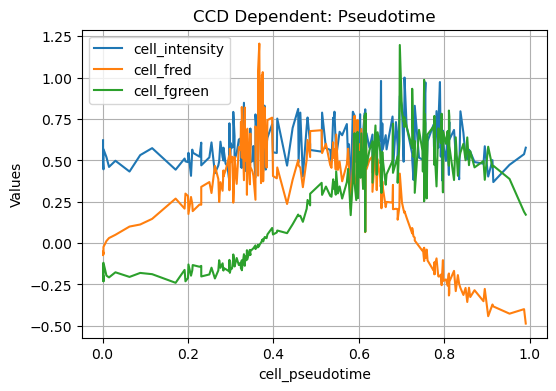

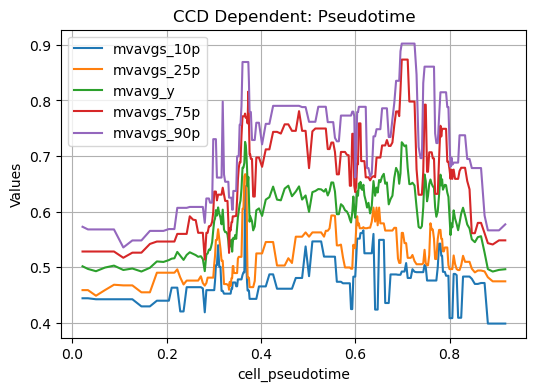

In [8]:
plot_data(300)

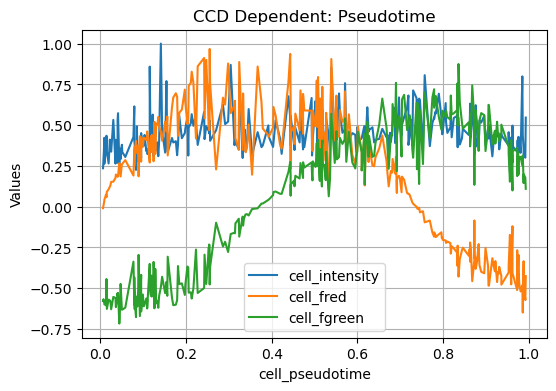

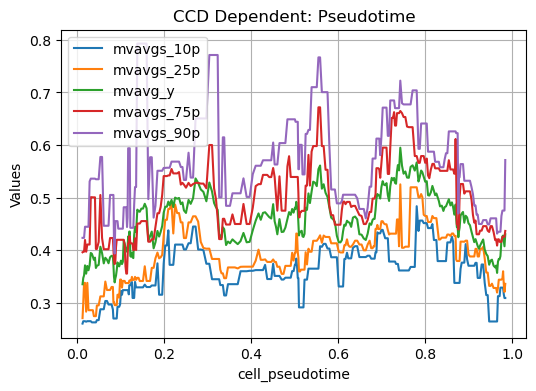

In [9]:
plot_data(185)

In [10]:
def get_mu_sigma(row_index, t_index):
    # takes too long
    percentiles = [10, 25, 50, 75, 90]

    row = protein.iloc[row_index]
    percentile_columns = ['mvavgs_10p', 'mvavgs_25p', 'mvavg_y', 'mvavgs_75p', 'mvavgs_90p']
    values = [row[col][t_index] for col in percentile_columns]

    # Function to minimize
    def minimize_function(params):
        mu, sigma = params
        estimated_percentiles = [stats.norm.ppf(x / 100., mu, sigma) for x in percentiles]
        return np.sum((np.array(estimated_percentiles) - np.array(values)) ** 2)

    # Optimization bounds on mu and sigma
    # in theory sigma should be less than 1/4 but data is probably not exactly gaussian
    bounds = [(0, 1), (1e-2, 1)]

    # Optimize
    result = differential_evolution(minimize_function, bounds, atol=1e-3)

    mu_opt, sigma_opt = result.x
    return mu_opt, sigma_opt

def get_mu_sigma_quick(row_index, t_index):
    row = protein.iloc[row_index]
    first_quartile = row['mvavgs_25p'][t_index]
    third_quartile = row['mvavgs_75p'][t_index]
    mu = row['mvavg_y'][t_index]
    sigma = (third_quartile - first_quartile) / (0.67448975 * 2)
    return mu, sigma

def get_mus_sigmas(row_index):
    mus, sigmas = [], []
    for t_index in range(len(protein.iloc[row_index]['mvavgs_10p'])):
        mu, sigma = get_mu_sigma_quick(row_index, t_index)
        mus.append(mu)
        sigmas.append(sigma)
    return mus, sigmas

def get_sigmas(row_index):
    mus, sigmas = [], []
    for t_index in range(len(protein.iloc[row_index]['mvavgs_10p'])):
        mu, sigma = get_mu_sigma_quick(row_index, t_index)
        mus.append(mu)
        sigmas.append(sigma)
    return mus, sigmas

In [11]:
protein['mus'], protein['sigmas'] = zip(*protein.apply(lambda row: get_mus_sigmas(row.name), axis=1))

In [15]:
protein['sigma_of_mus'] = protein['mus'].apply(lambda x: np.std(x))
protein['sigma_of_sigmas'] = protein['sigmas'].apply(lambda x: np.std(x))
# protein['sigma_of_intensity'] = protein['cell_intensity'].apply(lambda x: np.std(x))

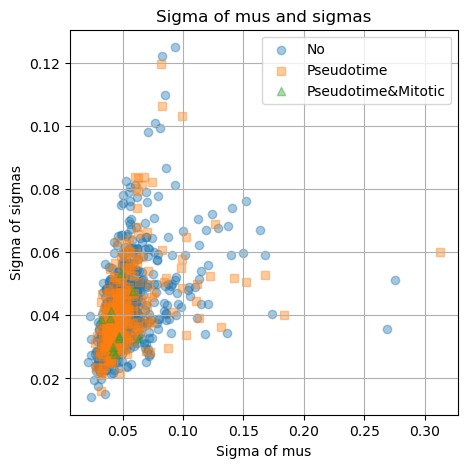

In [16]:
CCD_markers = {
    'No': 'o',
    'Pseudotime': 's',
    'Pseudotime&Mitotic': '^',
}

plt.figure(figsize=(5, 5))

for CCD_value, marker in CCD_markers.items():
    ccd_data = protein[protein['CCD'] == CCD_value]
    plt.scatter(
        ccd_data['sigma_of_mus'],
        ccd_data['sigma_of_sigmas'],
        label=CCD_value,
        marker=marker,
        alpha=0.4
    )
plt.xlabel('Sigma of mus')
plt.ylabel('Sigma of sigmas')
plt.legend()
plt.title('Sigma of mus and sigmas')
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 400x300 with 0 Axes>

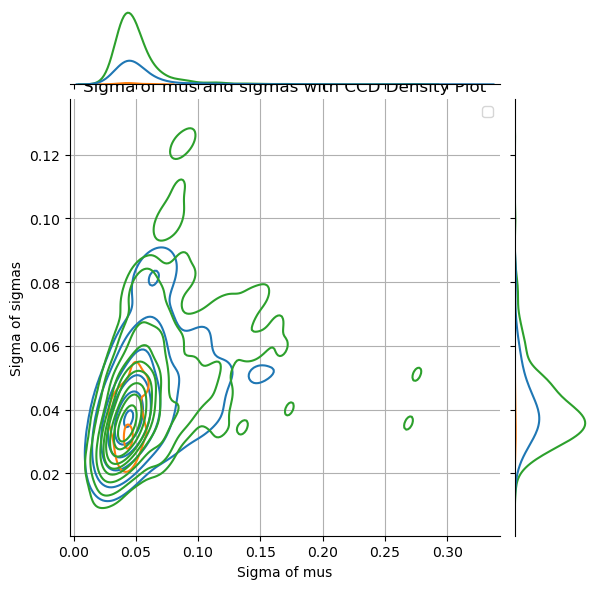

In [17]:
plt.figure(figsize=(4, 3))

sns.jointplot(x='sigma_of_mus', y = 'sigma_of_sigmas', data=protein, kind='kde', hue = 'CCD')

plt.xlabel('Sigma of mus')
plt.ylabel('Sigma of sigmas')
plt.legend()
plt.title('Sigma of mus and sigmas with CCD Density Plot')
plt.grid(True)
plt.show()

In [18]:
# regress a linear function to predict the CCD value for a given row
X = protein[['sigma_of_mus', 'sigma_of_sigmas']]
y = protein['CCD'].apply(lambda x: 0 if x == 'No' else 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=307)

# Create an SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.7094017094017094
Confusion Matrix:
[[166   0]
 [ 68   0]]


In [19]:
y_test.value_counts()

0    166
1     68
Name: CCD, dtype: int64